<a href="https://colab.research.google.com/github/ZARBOUBI-MOHAMED/CustomBottleneck-VGGNet_Tomato_Leaf_Diseases/blob/main/Models/CustomBottleneck-VGGNet/CustomBottleneck_VGGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to the Driver**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


# **Download the file.rar of the dataset to train the model**

In [ ]:
#  input_fil  ===>  output_folder
!unrar x "/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Dataset/Tomato_No_augmen.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3160).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3161).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3162).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3163).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3164).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3165).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3166).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3167).JPG      73%  OK 
Extracting  /content/Tomato_No_augmen/Train/Yellow Leaf Curl Virus/image (3168).JPG      

# **############ CustomBottleneck-VGGNet ##################**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, Add
import time

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
custom_path = "CustomBottleneck-VGGNet/"
filename_1 = "CustomBottleneck-VGGNet.png"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#************************************* input ***********************************

# Define the model input
x= 224
img_width, img_height = x, x
input_shape = (img_width, img_height, 3)
input_layer = layers.Input(shape=input_shape)

#*******************************************************************************
# Load the pre-trained VGG16 model without the fully connected layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the weights of the VGG16 layers up to "block2_pool"
for layer in vgg16_base.layers:
    if layer.name == 'block2_pool':
        break
    layer.trainable = False
#*******************************************************************************
# Get the output of "block1" layers
block1_conv1 = vgg16_base.get_layer('block1_conv1')(input_layer)
block1_conv2 = vgg16_base.get_layer('block1_conv2')(block1_conv1)
block1_pool = vgg16_base.get_layer('block1_pool')(block1_conv2)

# Get the output of "block2" layers
block2_conv1 = vgg16_base.get_layer('block2_conv1')(block1_pool)
block2_conv2 = vgg16_base.get_layer('block2_conv2')(block2_conv1)
block2_pool = vgg16_base.get_layer('block2_pool')(block2_conv2)
#*******************************************************************************
BatchN = layers.BatchNormalization()(block2_pool)
#*******************************************************************************

# Bottleneck_N1
bottleneck = layers.Conv2D(128, (1, 1), padding='valid')(BatchN)
bottleneck = layers.BatchNormalization()(bottleneck)
bottleneck = layers.Activation('relu')(bottleneck)
bottleneck = layers.Conv2D(128, (3, 3), padding='valid')(bottleneck)
bottleneck = layers.BatchNormalization()(bottleneck)
bottleneck = layers.Activation('relu')(bottleneck)
bottleneck = layers.Conv2D(128, (1, 1), padding='valid')(bottleneck)
bottleneck = layers.BatchNormalization()(bottleneck)
bottleneck_output = layers.Activation('relu')(bottleneck)

# Use the output of "block2_conv2" as input for the connected convolution
conv_output = layers.Conv2D(128, (3, 3), padding='valid')(BatchN)
conv_output = layers.BatchNormalization()(conv_output)
conv_output = layers.Activation('relu')(conv_output)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Add the output of the Bottleneck and the convolution
added_output_N1 = Add() ([bottleneck_output, conv_output])  # @@@ 1 @@@
added_output_N1 = layers.Activation('relu')(added_output_N1)
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Additional convolution
concatenated_output = layers.Conv2D(64, (3, 3), padding='valid')(added_output_N1)
concatenated_output = layers.BatchNormalization()(concatenated_output)
concatenated_output = layers.Activation('relu')(concatenated_output)

# Pooling
pooled_output = layers.MaxPooling2D((2, 2))(concatenated_output)

#*******************************************************************************

#  Bottleneck_N2
bottleneck_N2 = layers.Conv2D(64, (1, 1), padding='valid')(pooled_output)
bottleneck_N2 = layers.BatchNormalization()(bottleneck_N2)
bottleneck_N2 = layers.Activation('relu')(bottleneck_N2)
bottleneck_N2 = layers.Conv2D(64, (3, 3), padding='valid')(bottleneck_N2)
bottleneck_N2 = layers.BatchNormalization()(bottleneck_N2)
bottleneck_N2 = layers.Activation('relu')(bottleneck_N2)
bottleneck_N2 = layers.Conv2D(64, (1, 1), padding='valid')(bottleneck_N2)
bottleneck_N2 = layers.BatchNormalization()(bottleneck_N2)
bottleneck_output_N2 = layers.Activation('relu')(bottleneck_N2)

# Convolution connected to the output of MaxPooling
conv_output_N2 = layers.Conv2D(64, (3, 3), padding='valid')(pooled_output)
conv_output_N2 = layers.BatchNormalization()(conv_output_N2)
conv_output_N2 = layers.Activation('relu')(conv_output_N2)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Add the output of the Bottleneck and the convolution
added_output_N2 = Add() ([bottleneck_output_N2, conv_output_N2])  # @@@ 2 @@@
added_output_N2 = layers.Activation('relu')(added_output_N2)
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Additional convolution
concatenated_output_N2 = layers.Conv2D(64, (3, 3), padding='valid')(added_output_N2)
concatenated_output_N2 = layers.BatchNormalization()(concatenated_output_N2)
concatenated_output_N2 = layers.Activation('relu')(concatenated_output_N2)

# Pooling
pooled_output_N2 = layers.MaxPooling2D((2, 2))(concatenated_output_N2)

#*******************************************************************************
# Bottleneck_N3
bottleneck_N3 = layers.Conv2D(64, (1, 1), padding='valid')(pooled_output_N2)
bottleneck_N3 = layers.BatchNormalization()(bottleneck_N3)
bottleneck_N3 = layers.Activation('relu')(bottleneck_N3)
bottleneck_N3 = layers.Conv2D(64, (3, 3), padding='valid')(bottleneck_N3)
bottleneck_N3 = layers.BatchNormalization()(bottleneck_N3)
bottleneck_N3 = layers.Activation('relu')(bottleneck_N3)
bottleneck_N3 = layers.Conv2D(64, (1, 1), padding='valid')(bottleneck_N3)
bottleneck_N3 = layers.BatchNormalization()(bottleneck_N3)
bottleneck_output_N3 = layers.Activation('relu')(bottleneck_N3)

#*******************************************************************************
conv_output_N3 = layers.Conv2D(64, (3, 3), padding='valid')(pooled_output_N2)
conv_output_N3 = layers.BatchNormalization()(conv_output_N3)
conv_output_N3 = layers.Activation('relu')(conv_output_N3)
#*******************************************************************************

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Add the output of the Bottleneck and the convolution
added_output_N3 = Add()([bottleneck_output_N3, conv_output_N3])  # @@@ 3 @@@
added_output_N3 = layers.Activation('relu')(added_output_N3)

#*******************************************************************************
# Bottleneck_N4
bottleneck_N4 = layers.Conv2D(64, (1, 1), padding='valid')(added_output_N3)
bottleneck_N4 = layers.BatchNormalization()(bottleneck_N4)
bottleneck_N4 = layers.Activation('relu')(bottleneck_N4)
bottleneck_N4 = layers.Conv2D(64, (3, 3), padding='valid')(bottleneck_N4)
bottleneck_N4 = layers.BatchNormalization()(bottleneck_N4)
bottleneck_N4 = layers.Activation('relu')(bottleneck_N4)
bottleneck_N4 = layers.Conv2D(64, (1, 1), padding='valid')(bottleneck_N4)
bottleneck_N4 = layers.BatchNormalization()(bottleneck_N4)
bottleneck_output_N4 = layers.Activation('relu')(bottleneck_N4)

#*******************************************************************************
conv_output_N4 = layers.Conv2D(64, (3, 3), padding='valid')(added_output_N3)
conv_output_N4 = layers.BatchNormalization()(conv_output_N4)
conv_output_N4 = layers.Activation('relu')(conv_output_N4)
#*******************************************************************************

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Add the output of the Bottleneck and the convolution
added_output_N4 = Add()([bottleneck_output_N4, conv_output_N4])  # @@@ 4 @@@
added_output_N4 = layers.Activation('silu')(added_output_N4)
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#*******************************************************************************
#  Additional convolution
Convf = layers.Conv2D(64, (3, 3), padding='valid')(added_output_N4)
Convf = layers.BatchNormalization()(Convf )
Convf = layers.Activation('silu')(Convf )
#*******************************************************************************
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Add dropout after the third convolutional layer
Convf = layers.Dropout(0.5)(Convf)
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#*******************************************************************************
# Flatten the data to pass it through fully connected layers
flatten_output = layers.Flatten()(Convf)
#*******************************************************************************

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Output layer
output_Dense = layers.Dense(256, activation='silu')(flatten_output)

output_layer = layers.Dense(10, activation='softmax')(output_Dense)
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#*******************************************************************************
# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)
#*******************************************************************************

# Visualize the model
plot_model(model, to_file=f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_1}", show_shapes=True)

#plot_model(model, to_file='CustomBottleneck-VGGNet.png', show_shapes=True)

#*******************************************************************************
# Display a summary of the custom model
model.summary()
#*******************************************************************************

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[1][0]']        
                                                                                            

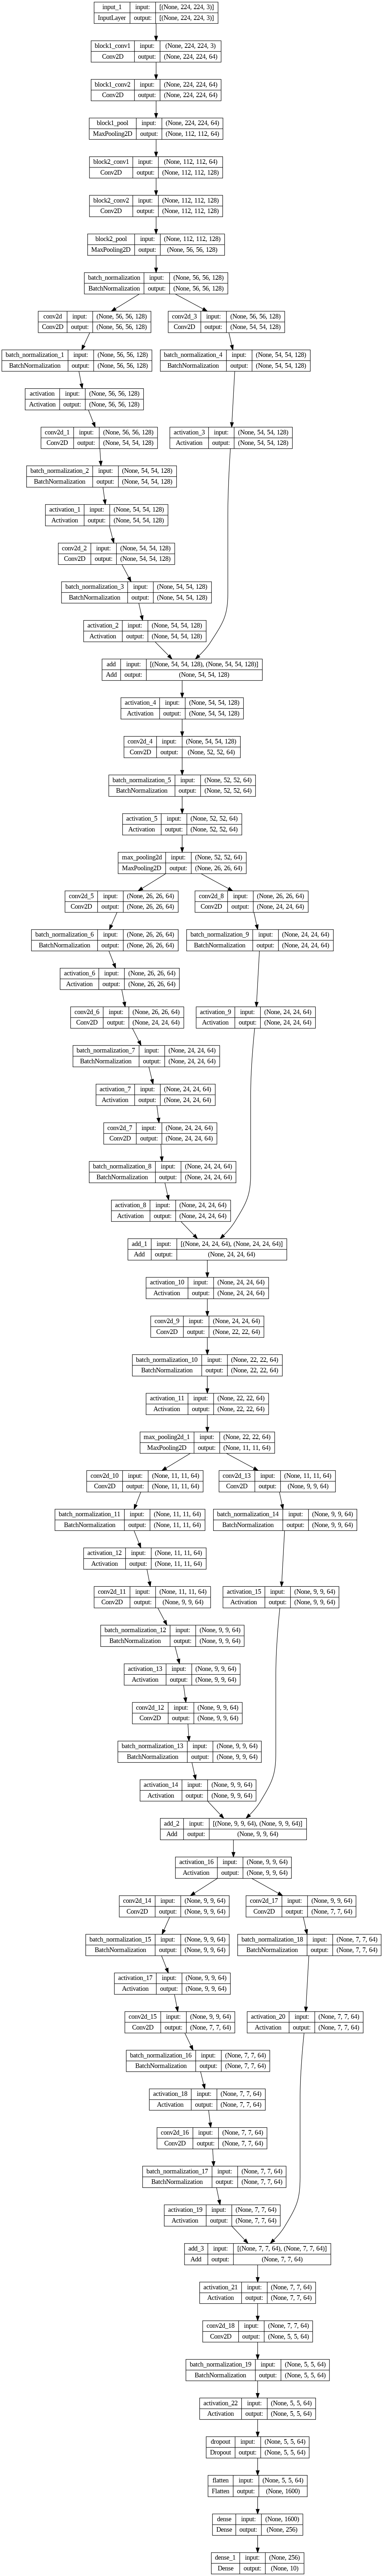

In [ ]:
plot_model(model, to_file=f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_1}", show_shapes=True)

# **Experiment Configuration**

In [ ]:
# Define the learning rate

learning_rate = 0.001

# Compile the model by specifying the learning rate

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define the paths of training and validation dataset
train_data_dir = '/content/Tomato_No_augmen/Train'
validation_data_dir = '/content/Tomato_No_augmen/Validation'

In [ ]:
# Use ImageDataGenerator only for pixel scaling
batch_size = 32
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 12707 images belonging to 10 classes.
Found 3641 images belonging to 10 classes.


In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
filename_2 = "Train/training_history.csv"
filename_3 = "Train/mon_modele_Archi.h5"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Train the model
epochs = 100   # Number of training epochs *****************
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Start the timer
start_time = time.time()

# Train the model while collecting the training history
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs)  # Add the CSVLogger callback

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Stop the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the history to a CSV file
history_df.to_csv('training_history.csv', index=False)

# Save the model after training if necessary
model.save('CustomBottleneck-VGGNet.h5')

# Save the history to a CSV file in Drive

history_df.to_csv(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_2}", index=False)

# Save the model in Drive
model.save(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_3}")



Epoch 1/100
397/397 [==============================] - 118s 232ms/step - loss: 0.9171 - accuracy: 0.6887 - val_loss: 1.8432 - val_accuracy: 0.6352
Epoch 2/100
397/397 [==============================] - 82s 207ms/step - loss: 0.4511 - accuracy: 0.8485 - val_loss: 1.2787 - val_accuracy: 0.6449
Epoch 3/100
397/397 [==============================] - 82s 206ms/step - loss: 0.3034 - accuracy: 0.8964 - val_loss: 0.5456 - val_accuracy: 0.8449
Epoch 4/100
397/397 [==============================] - 82s 206ms/step - loss: 0.2290 - accuracy: 0.9206 - val_loss: 0.2285 - val_accuracy: 0.9206
Epoch 5/100
397/397 [==============================] - 81s 205ms/step - loss: 0.1905 - accuracy: 0.9370 - val_loss: 0.8224 - val_accuracy: 0.8001
Epoch 6/100
397/397 [==============================] - 82s 206ms/step - loss: 0.1798 - accuracy: 0.9397 - val_loss: 0.3892 - val_accuracy: 0.8844
Epoch 7/100
397/397 [==============================] - 81s 205ms/step - loss: 0.1689 - accuracy: 0.9428 - val_loss: 0.2403 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Display and save each graph separately in EPS format**

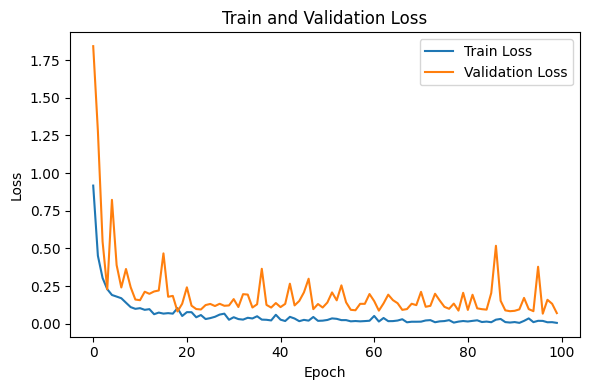

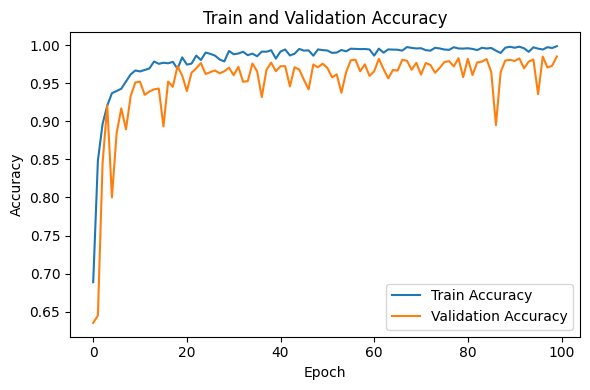

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
filename_4 = "Train/train_val_loss.eps"
filename_5 = "Train/train_val_accuracy.eps"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Display and save the loss graph
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.tight_layout()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_4}", format='eps', bbox_inches='tight')
plt.show()

# Display and save the accuracy graph
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.tight_layout()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_5}", format='eps', bbox_inches='tight')
plt.show()


# **Plot the training curves of loss and accuracy from the CSV file**

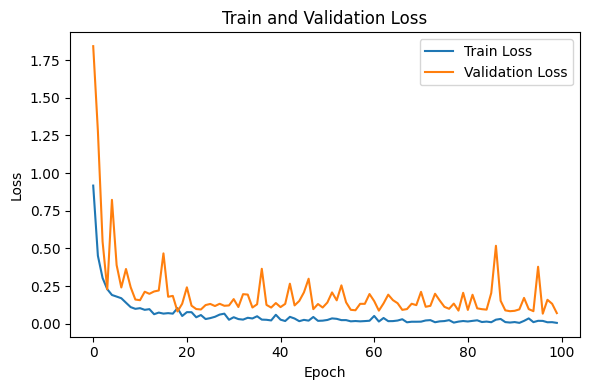

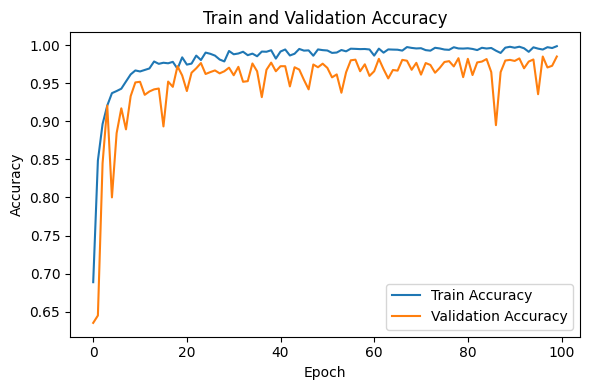

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
custom_path = "CustomBottleneck-VGGNet/"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
filename_6 = "Train/training_history.csv"
filename_7 = "Train/Train_val_loss_2.eps"
filename_8 = "Train/train_val_accuracy_2.eps"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Load training data from the CSV file
log_data = pd.read_csv(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_6}")

# Plot the loss graph
plt.figure(figsize=(6, 4))
plt.plot(log_data['loss'], label='Train Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.tight_layout()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_7}", format='eps', bbox_inches='tight')
plt.show()

# Plot the accuracy graph
plt.figure(figsize=(6, 4))
plt.plot(log_data['accuracy'], label='Train Accuracy')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.tight_layout()
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_8}", format='eps', bbox_inches='tight')
plt.show()


# **Test Model**

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
custom_path = "CustomBottleneck-VGGNet/"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Found 1812 images belonging to 10 classes.
57/57 [==============================] - 9s 147ms/step
Accuracy: 99.12%
Precision: 99.13%
Recall: 99.12%
F1 Score: 99.11%


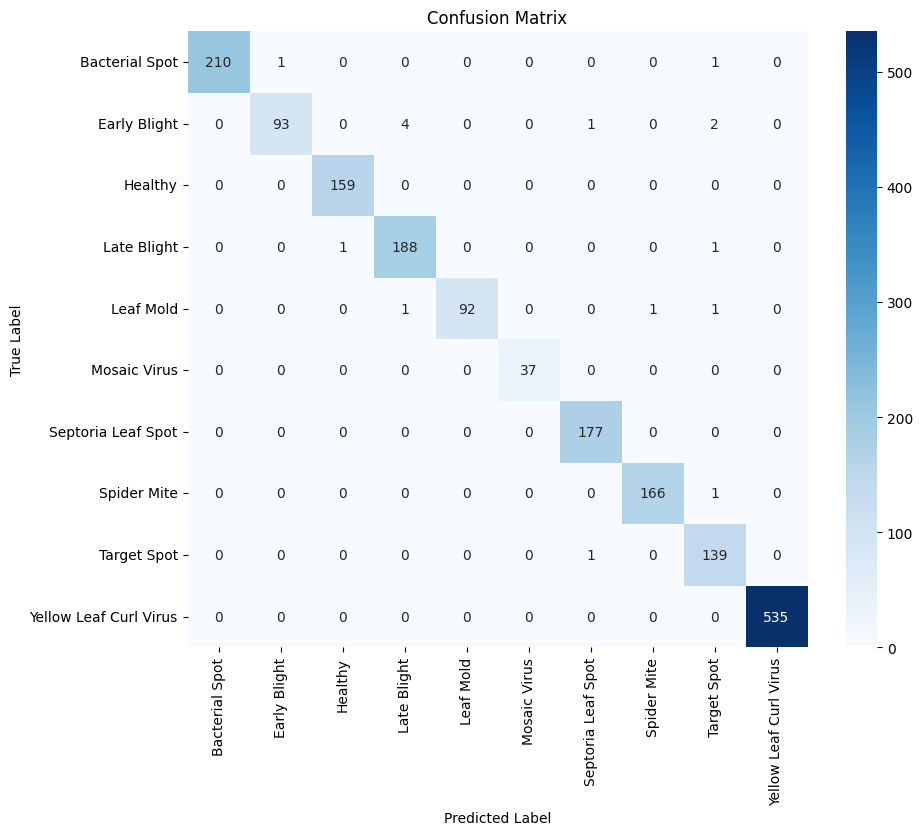

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
filename_9 = "Train/CustomBottleneck-VGGNet.h5"
filename_10 = "Train/confusion_matrix.eps"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Test directory

test_data_dir = '/content/Tomato_No_augmen/Test'

# Load the pre-trained model from the file
model = load_model(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_9}")

# Parameters for the images (size and scaling)
img_width, img_height = 224, 224
batch_size = 32

# Create a data generator for scaling the test images
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Use the model to make predictions on the test data
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure the data remains in the correct order

# Model predictions on the test data
predictions = model.predict(test_generator, steps=(test_generator.samples + batch_size - 1) // batch_size)

# Get the true labels from the test data
true_labels = test_generator.classes

# Get the predicted classes
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
class_names = list(test_generator.class_indices.keys())

# Create a figure with a specific size in inches
plt.figure(figsize=(10, 8))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')



# Compute the metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Display the metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Save the confusion matrix in EPS format
plt.savefig(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_10}", format='eps', bbox_inches='tight')
plt.show()


# **Conversion to TensorFlow Lite Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
filename_9 = "Train/CustomBottleneck-VGGNet.h5"
filename_11 = "Model_tflite/model.tflite"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
custom_path = "CustomBottleneck-VGGNet/"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Load the .h5 model
model = tf.keras.models.load_model(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_9}")

# Convert to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_11}", 'wb') as f:
    f.write(tflite_model)

# **Calculate the number of FLOPs (Floating Point Operations per Second)**

In [ ]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
custom_path = "CustomBottleneck-VGGNet/"
filename_9 = "Train/CustomBottleneck-VGGNet.h5"
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model(f"/content/gdrive/MyDrive/Colab Notebooks/Tomato_Leaf_Diseases/Models/{custom_path}{filename_9}")

# Create a concrete function
@tf.function
def model_fn(inputs):
    return model(inputs)

# Convert the model to a concrete function
input_shape = model.input_shape[1:]  # Exclude batch size
inputs = tf.TensorSpec([1, *input_shape], tf.float32)  # Batch size of 1
concrete_function = model_fn.get_concrete_function(inputs)

# Get the frozen graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
frozen_func = convert_variables_to_constants_v2(concrete_function)
graph_def = frozen_func.graph.as_graph_def()

# Calculate FLOPs using tf.compat.v1
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess:
    tf.compat.v1.import_graph_def(graph_def, name="")
    flops = tf.compat.v1.profiler.profile(
        sess.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation(),
    )

    # Display FLOPs in billions
    flops_in_billions = flops.total_float_ops / 1e9
    print(f"FLOPs: {flops_in_billions:.2f} Billion")

FLOPs: 11.92 Billion
